# Radio ML Classification - CNN Approach

Solution to the RadioML classification challenge using CNNs.

In [1]:
# Loading Data

pathToDataset = "C:/Users/aksha/Documents/Jupyter Notebooks/radioml-classification/Datasets/Standard/RML2016.10a_dict.pkl"

# Extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open(pathToDataset,'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Description of Data

The dataset has the size 220,000×2×128, which means that there are 220,000 entries, each consisting of an array of size 2 × 128. Each array represents the samples of about 128 µs of a received waveform sampled with approximately 106 samples/second, and it contains between 8 and 16 modulation symbols. Since the samples of the signal waveforms are complex-valued, they have been stored as real and imaginary parts, and therefore we have arrays of size 2 × 128 in the data set.

That is, each row is essentially, **a + ib**.

The labels of the downloaded dataset contain two parameters: the modulation technique used (one of [’8PSK’, ’AM-DSB’, ’AM-SSB’, ’BPSK’,’CPFSK’, ’GFSK’, ’PAM4’, ’QAM16’, ’QAM64’, ’QPSK’, ’WBFM’], so 11 possible modulation techniques), and the signal-to noise ratio (SNR) value (one of [−20, −18, −16, −14, −12, −10, −8, −6, −4, −2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18], so 20 possible SNR values). The SNR is a measure for the quality of the communication channel. The higher the SNR, the less “noisy” is the channel.

Each item of the list is essentially like **(b'Modulation Type',SNR Value)** [Use os.fsdecode to extract Modulation Type as string] 

In [2]:
# Import Necessary Packages
%matplotlib inline
import os
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, LayerNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import numpy as np

# Data Processing

The goal of this stage is to split data into Training, Validation and Testing data and then process the available data and transform (if needed) it into relevant inputs to be fed into the CNN.

1. Split Dataset into Training, Validation and Testing Data : 110,000 samples for training and validation and 110,000 samples for testing.

In [3]:
#  into training and test sets of the form we can train/test on 
random.seed(777)
np.random.seed(777)

index = np.arange(0,220000)
random.shuffle(index)

trainIdx = index[0:110000]
testIdx = index[110000:220000]

trainX = X[trainIdx]


# Create Validation Data Set
indexVal = np.arange(0,110000)
random.shuffle(indexVal)

realTrainIdx = indexVal[0:99000] 
valIdx = indexVal[99000:110000]

# Actual Training Data
realTrainX = trainX[realTrainIdx]
X_train = np.expand_dims(realTrainX, axis=-1) # Important

# Actual Validation Data
validX = trainX[valIdx]
X_valid = np.expand_dims(validX, axis=-1) # Important

# Actual Testing Data
testX = X[testIdx]
X_test = np.expand_dims(testX, axis=-1) # Important

In [4]:
# One Hot Encode Labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
ytrain=lbl_encoded[trainIdx]

y_train = ytrain[realTrainIdx]
y_valid = ytrain[valIdx]
y_test=lbl_encoded[testIdx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


# Design Neural Network

In [5]:
# Network Parameters
dropoutRate = 0.5

# Structure
inpShape = (2,128,1) # Shape of Input Data
CNN1_numFilt = 256 # Number of Filters in CNN Layer 1
CNN1_kernSize = (1,3) # Kernel Size of CNN Layer 1

CNN2_numFilt = 80 # Number of Filters in CNN Layer 2
CNN2_kernSize = (2,3) # Kernel Size of CNN Layer 2

Dense1_numNeurons = 128 # Number of Nodes in the First Dense Layer
numOutput = 11 # Number of Output Nodes

# Weight Initialization
weightInit = 'glorot_uniform' # Xavier Initialization

# Activation Functions
activationHidden = 'relu'
activationOutput = 'softmax'

# Loss Function
lossFunction = 'categorical_crossentropy'

# Learning Algorithm
netOptimizer = 'adam'

# Callbacks
callbackList = [
        tensorflow.keras.callbacks.ModelCheckpoint('Data/CNN-15/CNN-15-Weights_best.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='auto')]

# Construct Network
model = models.Sequential()
#model.add(BatchNormalization(axis=-1,input_shape=inpShape, name='Normalization_1'))
#model.add(ZeroPadding2D(padding=(0,1),name='ZPad1'))
model.add(Convolution2D(filters=512, kernel_size=CNN1_kernSize,input_shape=inpShape, padding='same', activation=activationHidden, name='Conv_1'))
model.add(MaxPooling2D(pool_size=(1,2),padding='same'))
model.add(Dropout(dropoutRate))

model.add(Convolution2D(filters=256, kernel_size=CNN1_kernSize,padding='same', activation=activationHidden, name='Conv_2'))
model.add(MaxPooling2D(pool_size=(1,2),padding='same'))
model.add(Dropout(dropoutRate))

model.add(Convolution2D(filters=128, kernel_size=CNN1_kernSize,padding='same', activation=activationHidden, name='Conv_3'))
model.add(MaxPooling2D(pool_size=(1,2),padding='same'))
model.add(Dropout(dropoutRate))

model.add(Convolution2D(filters=64, kernel_size=CNN1_kernSize,padding='same', activation=activationHidden, name='Conv_4'))
model.add(MaxPooling2D(pool_size=(1,2),padding='same'))
model.add(Dropout(dropoutRate))

model.add(Flatten())
model.add(Dense(Dense1_numNeurons, activation=activationHidden))
model.add(Dense(numOutput, activation=activationOutput))
model.compile(loss=lossFunction, optimizer=netOptimizer,metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 2, 128, 512)       2048      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 64, 512)        0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 64, 512)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 2, 64, 256)        393472    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 32, 256)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 32, 256)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 2, 32, 128)        9

# Train Network

In [6]:
numEpochs = 100
batchSize = 1024

In [7]:
history = model.fit(X_train,y_train,epochs=numEpochs,batch_size=batchSize,validation_data=(X_valid,y_valid),callbacks=callbackList,verbose=2)

Train on 99000 samples, validate on 11000 samples
Epoch 1/100
99000/99000 - 45s - loss: 2.3609 - categorical_accuracy: 0.1126 - val_loss: 2.1676 - val_categorical_accuracy: 0.2102
Epoch 2/100
99000/99000 - 35s - loss: 1.9053 - categorical_accuracy: 0.2869 - val_loss: 1.6723 - val_categorical_accuracy: 0.3615
Epoch 3/100
99000/99000 - 35s - loss: 1.6405 - categorical_accuracy: 0.3797 - val_loss: 1.5429 - val_categorical_accuracy: 0.4294
Epoch 4/100
99000/99000 - 35s - loss: 1.5465 - categorical_accuracy: 0.4199 - val_loss: 1.4678 - val_categorical_accuracy: 0.4556
Epoch 5/100
99000/99000 - 35s - loss: 1.5007 - categorical_accuracy: 0.4348 - val_loss: 1.4603 - val_categorical_accuracy: 0.4565
Epoch 6/100
99000/99000 - 35s - loss: 1.4747 - categorical_accuracy: 0.4446 - val_loss: 1.4420 - val_categorical_accuracy: 0.4515
Epoch 7/100
99000/99000 - 35s - loss: 1.4505 - categorical_accuracy: 0.4520 - val_loss: 1.3970 - val_categorical_accuracy: 0.4845
Epoch 8/100
99000/99000 - 35s - loss: 1.

In [8]:
# Save History
np_loss_history = np.array(history.history["loss"])
np.save('Data/CNN-15/lossHist.npy',np_loss_history)

np_accu_history = np.array(history.history["categorical_accuracy"])
np.save('Data/CNN-15/accuHist.npy',np_accu_history)

np_val_loss_history = np.array(history.history["val_loss"])
np.save('Data/CNN-15/valLossHist.npy',np_val_loss_history)

np_val_accu_history = np.array(history.history["val_categorical_accuracy"])
np.save('Data/CNN-15/valAccuHist.npy',np_val_accu_history)

# Test/Evaluate Network

In [6]:
# Re-load Best Weights
model.load_weights('Data/CNN-15/CNN-15-Weights_best.h5')

model.evaluate(X_test,y_test)

110000/110000 [==============================] - 45s 409us/sample - loss: 1.2143 - categorical_accuracy: 0.5304


[1.2142722093928944, 0.5304273]

# Visualize Results

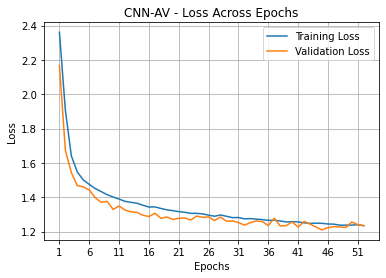

In [7]:
# Load Details of History
lHist = np.load('Data/CNN-15/lossHist.npy')
aHist = np.load('Data/CNN-15/accuHist.npy')

vLHist = np.load('Data/CNN-15/valLossHist.npy')
vAHist = np.load('Data/CNN-15/valAccuHist.npy')

# Show loss curves 
plt.figure()
plt.title('CNN-AV - Loss Across Epochs')
plt.plot(lHist, label='Training Loss')
plt.plot(vLHist, label='Validation Loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(0,55,5),np.arange(1,55,5))
plt.ylabel('Loss')
plt.grid()
plt.legend()

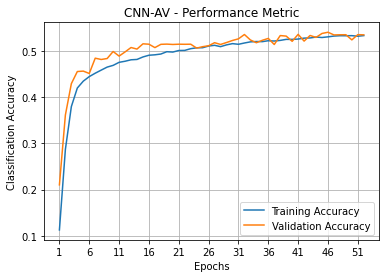

In [8]:
# Show Accuracy curves 
plt.figure()
plt.title('CNN-AV - Performance Metric')
plt.plot(aHist, label='Training Accuracy')
plt.plot(vAHist, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0,55,5),np.arange(1,55,5))
plt.ylabel('Classification Accuracy')
plt.grid()
plt.legend()

In [23]:
# Function to Extract Test Data of Specific SNR
def extractTest(data,labels,labelsEncoded,testIndex,snr):
    testData = data[testIndex]
    labelArray = np.array([labels])
    testLabels = labelArray[:,testIdx,:]
    testLabelsEncoded = labelsEncoded[testIdx]
    
    idxOP = list()
    
    # Loop Through Label Array To Get Index of Specific SNR
    for i in range(0,testLabels.shape[1]):
        if testLabels[0,i,1].decode('ascii')==snr:
            idxOP.append(i)
    
    # Return Subset of Test Data and Corresponding Labels
    opTestData = np.expand_dims(testData[idxOP,:,:],axis=-1)
    opTestLabel = testLabelsEncoded[idxOP]
    
    return opTestData, opTestLabel

def plot_confusion_matrix(cm, titleAdd, title='CNN-AV Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+titleAdd)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Confusion Matrix Function
def prepConfMat(testData,testLabel,predTestLabel,mods,title):
    modString = list()
    for i in range(0,len(mods)):
        modString.append(mods[i].decode('ascii'))
    
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,testData.shape[0]):
        j = list(testLabel[i,:]).index(1)
        k = int(np.argmax(predTestLabel[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, title, labels=modString)

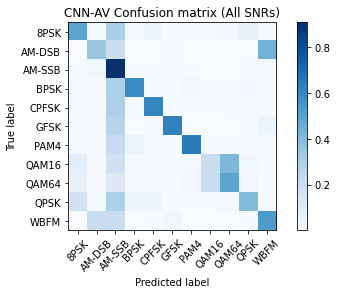

In [24]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=1024)

prepConfMat(X_test,y_test,test_Y_hat,mods,' (All SNRs)')

In [9]:
# Plot Confusion Matrix for Specific SNR
snr = '-4'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
y_hat_snr = model.predict(x_testSNR, batch_size=1024)
prepConfMat(x_testSNR,y_TestSNR,y_hat_snr,mods,title)

NameError: name 'extractTest' is not defined

In [14]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[testIdx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.0967741935483871 for SNR b'-20'
Overall Accuracy:  0.09676833696441539 for SNR b'-18'
Overall Accuracy:  0.0973111395646607 for SNR b'-16'
Overall Accuracy:  0.12163636363636364 for SNR b'-14'
Overall Accuracy:  0.1654378708865312 for SNR b'-12'
Overall Accuracy:  0.2339761248852158 for SNR b'-10'
Overall Accuracy:  0.34085532302092814 for SNR b'-8'
Overall Accuracy:  0.48776978417266187 for SNR b'-6'
Overall Accuracy:  0.5912502288120081 for SNR b'-4'
Overall Accuracy:  0.6940243452600516 for SNR b'-2'
Overall Accuracy:  0.724963976945245 for SNR b'0'
Overall Accuracy:  0.7727022564667033 for SNR b'2'
Overall Accuracy:  0.7555953446732319 for SNR b'4'
Overall Accuracy:  0.7807380738073807 for SNR b'6'
Overall Accuracy:  0.7691449814126394 for SNR b'8'
Overall Accuracy:  0.7809954751131222 for SNR b'10'
Overall Accuracy:  0.7781227173119065 for SNR b'12'
Overall Accuracy:  0.7813876651982379 for SNR b'14'
Overall Accuracy:  0.7582757366315024 for SNR b'16'
Overall 

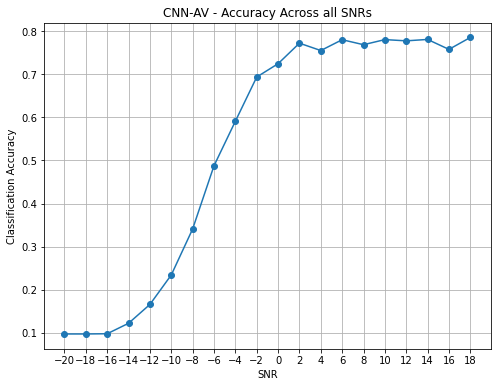

In [26]:
# Show loss curves 
plt.figure(figsize=(8, 6))
plt.title('CNN-AV - Accuracy Across all SNRs')
plt.plot(np.arange(-20,20,2), acc_array, marker='.',markersize=12)
plt.xlabel('SNR')
plt.xticks(np.arange(-20,20,2))
plt.ylabel('Classification Accuracy')
plt.grid()
plt.show()

In [17]:
accRes = np.array([acc_array])
np.save('Data/CNN-15/accResSNR.npy',accRes)